In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.animation as animation

import pickle as pkl

from enum import Enum

from sentinelhub import CRS, BBoxSplitter, BBox

from shapely.geometry import Polygon

from eolearn.io.local_io import *
from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling


# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, InterpolationTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

from tqdm import tqdm 

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Paths

In [2]:
data_path     = Path('../data')
sentinel_path = data_path/'sentinel'

output_path   = Path('output')
shape_path    = output_path/'shapes'
patch_path    = output_path/'patches'
feature_path  = output_path/'features'

train_patchlet_path = output_path/'train_patchlets'
test_patchlet_path  = output_path/'test_patchlets'

shape_path.mkdir(exist_ok=True, parents=True)
patch_path.mkdir(exist_ok=True, parents=True)
feature_path.mkdir(exist_ok=True, parents=True)

train_patchlet_path.mkdir(exist_ok=True, parents=True)
test_patchlet_path.mkdir(exist_ok=True, parents=True)

### Sample training patchlets

In [3]:
patch = EOPatch.load(feature_path/f'eopatch_0')

In [4]:
patch

EOPatch(
  data: {
    COMPOSITE_MAX_NDVI: numpy.ndarray(shape=(1, 1345, 1329, 6), dtype=float64)
    COMPOSITE_MAX_NDVI_HOG: numpy.ndarray(shape=(1, 1345, 1329, 9), dtype=float64)
    COMPOSITE_MAX_NDVI_HOG_VISU: numpy.ndarray(shape=(1, 1345, 1329, 1), dtype=float64)
    COMPOSITE_MAX_NDVI_LBP: numpy.ndarray(shape=(1, 1345, 1329, 6), dtype=float64)
    COMPOSITE_MIN_NDVI: numpy.ndarray(shape=(1, 1345, 1329, 6), dtype=float64)
    COMPOSITE_MIN_NDVI_HOG: numpy.ndarray(shape=(1, 1345, 1329, 9), dtype=float64)
    COMPOSITE_MIN_NDVI_HOG_VISU: numpy.ndarray(shape=(1, 1345, 1329, 1), dtype=float64)
    COMPOSITE_MIN_NDVI_LBP: numpy.ndarray(shape=(1, 1345, 1329, 6), dtype=float64)
    FEATURES: numpy.ndarray(shape=(8, 1345, 1329, 6), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_B4: numpy.ndarray(shape=(1345, 1329, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(1345, 1329, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape

In [5]:
def save_samples(patch_path, patch_idx, out_path, size=64, sample_factor=25):
    
    patch_path = Path(patch_path)
    out_path = Path(out_path)
    
    out_path.mkdir(exist_ok=True, parents=True)
    
    patch = EOPatch.load(patch_path/f'eopatch_{patch_idx}')
    
    half_size = size//2
    
    targets = patch.mask_timeless['LULC']
    
    patch_shape = targets.shape
    
    shape_x = patch_shape[0]
    shape_y = patch_shape[1]
    
    features = patch.data['FEATURES'] # R G B NIR NDVI NORM
    
    non_empty_targets = np.indices(patch_shape)[:,targets!=0]
    
    target_xs = non_empty_targets[0]
    target_ys = non_empty_targets[1]

    target_count = len(target_xs)
    
    samples = (target_count*sample_factor)//(size**2)
    
    #print(f'saving {samples} patchlets from patch {patch_idx}')

    for i in range(samples):
        index = np.random.randint(target_count)
        
        x_offset = np.clip(target_xs[index], half_size, shape_x-half_size) # ensure sample won't exceed patch
        y_offset = np.clip(target_ys[index], half_size, shape_y-half_size) # ensure sample won't exceed patch
        
        targ_arr = targets [x_offset-half_size:x_offset+half_size, y_offset-half_size:y_offset+half_size,0]
        feat_arr = features[:,x_offset-half_size:x_offset+half_size, y_offset-half_size:y_offset+half_size,:]
        
        targ_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl'
        feat_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_feat.pkl'
        
        pkl.dump(targ_arr, open(out_path/targ_fn,'wb'))
        pkl.dump(feat_arr, open(out_path/feat_fn,'wb'))
    
    del patch

In [6]:
# for patch_idx in tqdm(range(12)):
#     save_samples(patch_path=feature_path, 
#                  patch_idx=patch_idx, 
#                  out_path=train_patchlet_path, 
#                  size=64, 
#                  sample_factor=25)

### Have a look at the targets per patchlet

In [8]:
class LULC(Enum):
    NO_DATA        = (0,  'No Data',          'black')
    COTTON         = (1,  'Cotton',           'xkcd:lime')
    DATES          = (2,  'Dates',            'xkcd:darkgreen')
    GRASS          = (3,  'Grass',            'orange')
    LUCERN         = (4,  'Lucern',           'xkcd:tan')
    MAIZE          = (5,  'Maize',            'xkcd:azure')
    PECAN          = (6,  'Pecan',            'xkcd:lightblue')
    VACANT         = (7,  'Vacant',           'xkcd:beige')
    VINEYARD       = (8,  'Vineyard',         'crimson')
    VINEYARD_PECAN = (9,  'Vineyard & Pecan', 'xkcd:lavender')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

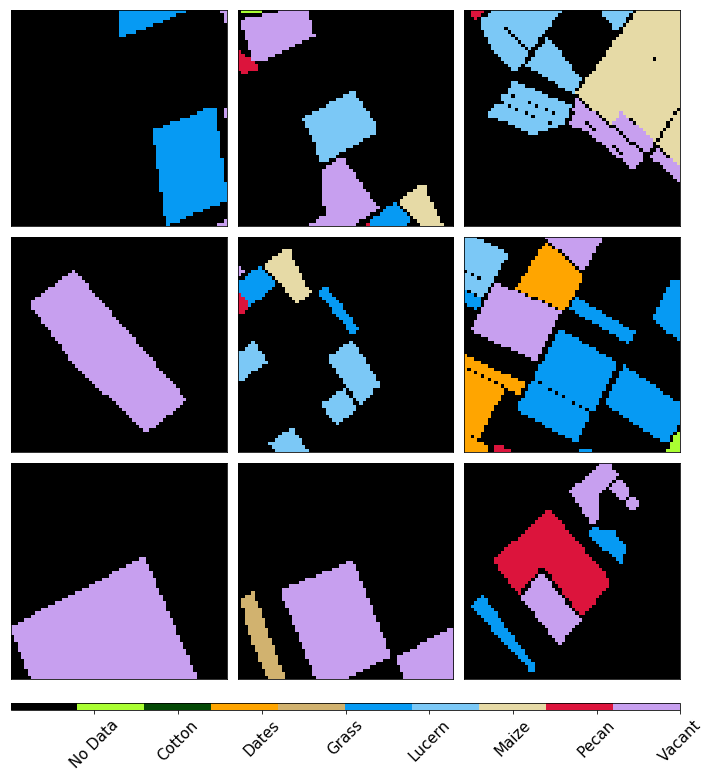

In [9]:
%matplotlib inline

targs = [str(f) for f in train_patchlet_path.glob('patch_10_*_targ.pkl')][:9]

fig = plt.figure(figsize=(12,15))

for i,f in enumerate(targs):
    ax = plt.subplot(3, 3, i+1)
    targ = pkl.load(open(f,'rb'))
    im=plt.imshow(targ, cmap=lulc_cmap)
    plt.xticks([])
    plt.yticks([])
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.03, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id+1 for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

In [10]:
fps = 1
nSeconds = 8

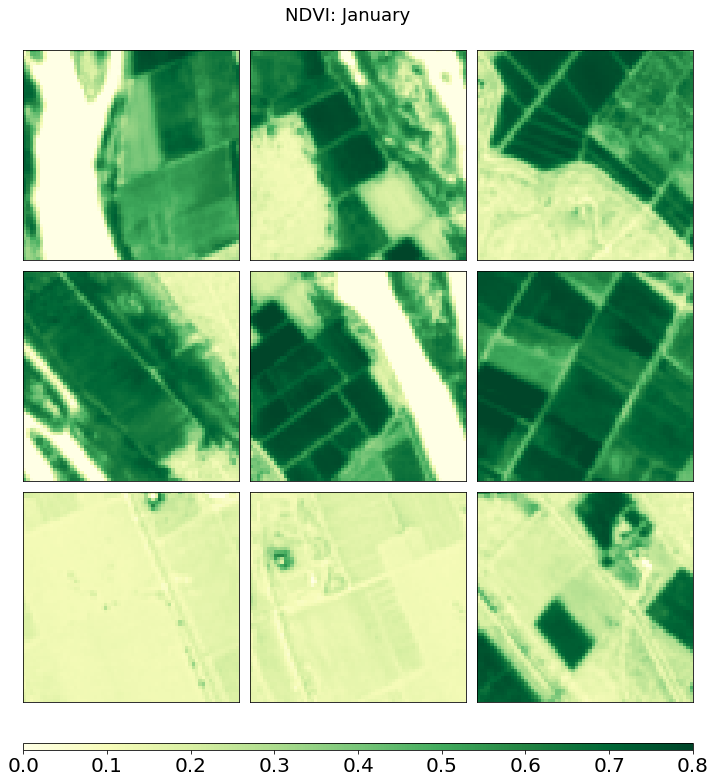

In [11]:
fig, axes = plt.subplots(3,3,sharey=True,sharex=True, figsize=(12,15))
plt.xticks([])
plt.yticks([])

fig.subplots_adjust(wspace=0.05, hspace=0.05)

feats = [str(f).replace('targ','feat') for f in targs]

datas = [[pkl.load(open(feat,'rb'))[i,...,-2] for i in range(8)] for feat in feats]

imgs = [axes[j//3,j%3].imshow(datas[j][0], interpolation='none', aspect='auto', 
                              vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
      for j in range(len(feats))]

cb = fig.colorbar(imgs[0], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, aspect=100)
cb.ax.tick_params(labelsize=20)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
def animate_func(i):
    fig.suptitle(f'NDVI: {months[i]}', y=0.92, size=18)
    for j in range(len(feats)):
        imgs[j].set_array(datas[j][i])
    return [imgs]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('nvdi.gif', writer=mpl.animation.PillowWriter(fps=fps))

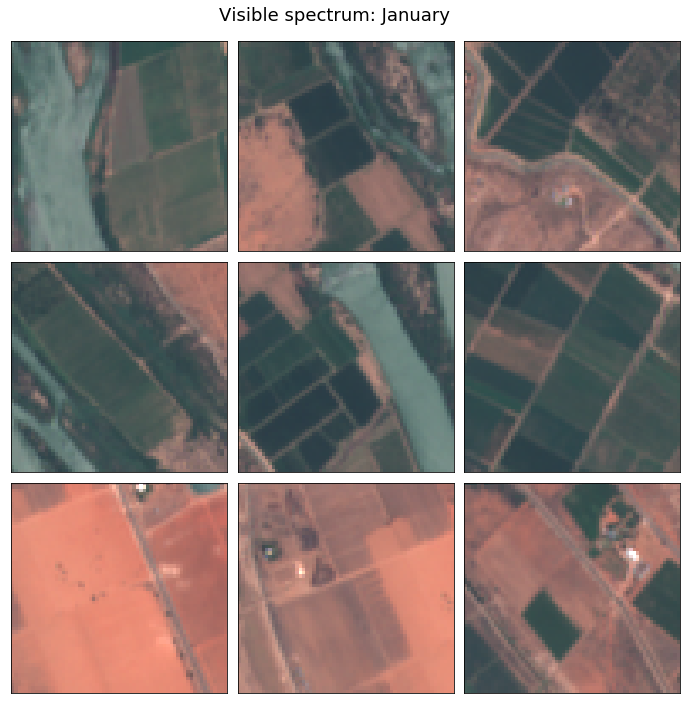

In [12]:
fig, axes = plt.subplots(3,3,sharey=True,sharex=True, figsize=(12,12))
plt.xticks([])
plt.yticks([])

fig.subplots_adjust(wspace=0.05, hspace=0.05)
feats = [str(f).replace('targ','feat') for f in targs]

datas = [[np.clip(pkl.load(open(feat,'rb'))[i,...,0:3]*3.5,0,1) for i in range(8)] for feat in feats]

imgs = [axes[j//3,j%3].imshow(datas[j][0], interpolation='none', aspect='auto', cmap=plt.get_cmap('YlGn'), vmin=0, vmax=1) 
      for j in range(len(feats))]

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
def animate_func(i):
    fig.suptitle(f'Visible spectrum: {months[i]}', y=0.92, size=18)
    for j in range(len(feats)):
        imgs[j].set_array(datas[j][i])
    return [imgs]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('visible_spectrum.gif', writer=mpl.animation.PillowWriter(fps=fps))



### Make test dataset

In [13]:
def save_test_grid(patch_path, patch_idx, out_path, size=64):
    
    patch_path = Path(patch_path)
    out_path = Path(out_path)
    
    out_path.mkdir(exist_ok=True, parents=True)
    
    patch = EOPatch.load(patch_path/f'eopatch_{patch_idx}')
    
    half_size = size//2
    
    test_field_ids = patch.mask_timeless['FIELD_ID']
    
    patch_shape = test_field_ids.squeeze().shape
    
    shape_x = patch_shape[0]
    shape_y = patch_shape[1]
    
    features = patch.data['FEATURES'] # R G B NDVI

    c = (shape_x//size)+1
    r = (shape_y//size)+1

    for i in range(c):
        for j in range(r):
            x_offset = i*64
            y_offset = j*64
            
            field_id_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl'
            feat_fn     = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_feat.pkl'
            
            patchlet_field_ids = test_field_ids[x_offset:x_offset+size, 
                                                y_offset:y_offset+size,...]
        
            if patchlet_field_ids.max() > 0:
                
                feat_arr = features[:,x_offset:x_offset+size, 
                                      y_offset:y_offset+size,:]
                
                if (patchlet_field_ids.shape[0] < size) or (patchlet_field_ids.shape[1] < size):
                    short_x = size - patchlet_field_ids.shape[0]
                    short_y = size - patchlet_field_ids.shape[1]
                    
                    patchlet_field_ids = np.pad(patchlet_field_ids, 
                                                   ((0,short_x),(0,short_y),(0,0)), 
                                                   mode='constant', 
                                                   constant_values=0)

                    feat_arr           = np.pad(feat_arr, 
                                                   ((0,0),(0,short_x),(0,short_y),(0,0)), 
                                                   mode='reflect')
                pkl.dump(patchlet_field_ids, open(out_path/field_id_fn,'wb'))
                pkl.dump(feat_arr, open(out_path/feat_fn,'wb'))
    del patch

In [14]:
# for i in tqdm(range(12)):
#     save_test_grid(patch_path=feature_path, patch_idx=i, out_path=test_patchlet_path)

In [46]:
def display_test_grid(patch_idx, patchlet_path, shape_x=1335, shape_y=1353, size=64):
    
    fig = plt.figure(figsize=(15,15))
    
    patchlet_path = Path(patchlet_path)
    
    c = (shape_x//size)+1
    r = (shape_y//size)+1

    for i in range(r):
        for j in range(c):
            x_offset = i*64
            y_offset = j*64
            
            ax = plt.subplot(r,c, i*c + j+1)

            plt.xticks([])
            plt.yticks([])
            ax.set_aspect("auto")
            
            field_id_fn = Path(patchlet_path/f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl')

            if field_id_fn.exists():
                patchlet = pkl.load(open(field_id_fn,'rb'))
                im = plt.imshow(patchlet.squeeze(),vmin=0,vmax=3600)
    
                                
    cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.5, aspect=100)
    fig.suptitle(f'Grid of all field polygons in Patch {patch_idx}: coloured by Field ID', y=0.92, size=20)
                                
    cb.ax.tick_params(labelsize=20)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

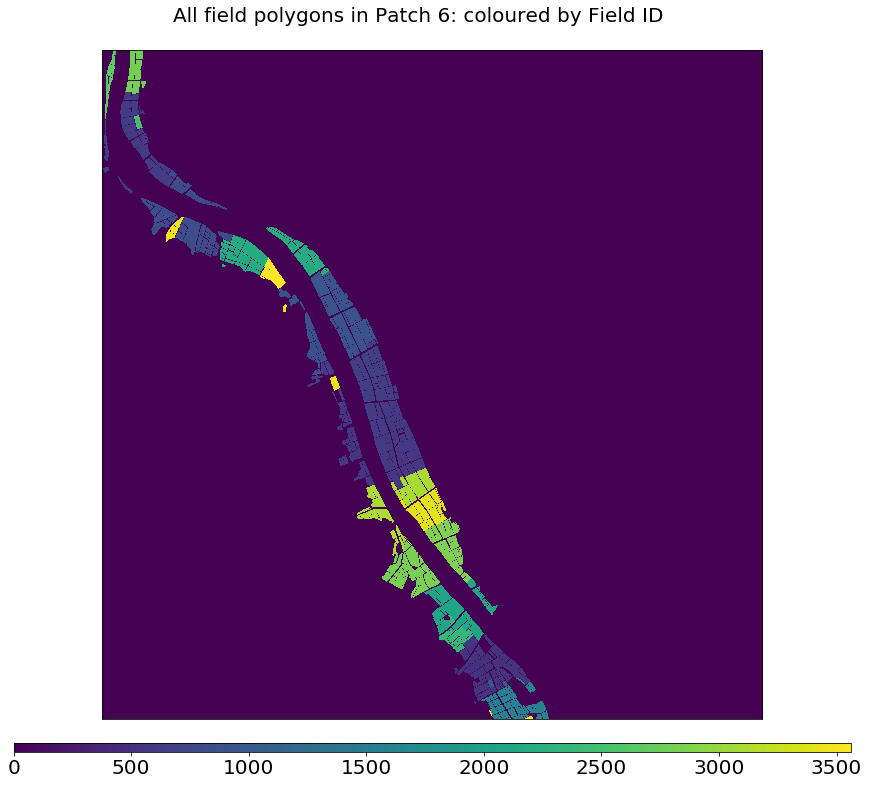

In [48]:
patch_idx=6

test_field_ids = EOPatch.load(feature_path/f'eopatch_{patch_idx}').mask_timeless['FIELD_ID'].squeeze()

fig = plt.figure(figsize=(15,15))
im = plt.imshow(test_field_ids)
plt.xticks([])
plt.yticks([])

fig.suptitle(f'All field polygons in Patch {patch_idx}: coloured by Field ID', y=0.92, size=20)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.03, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

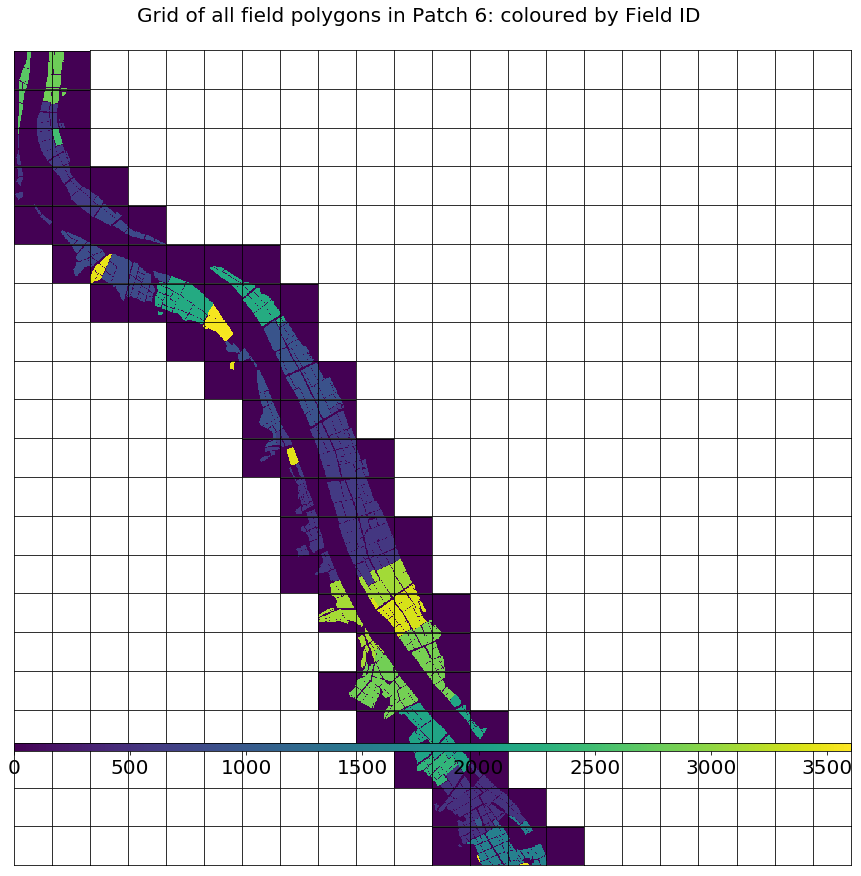

In [47]:
display_test_grid(patch_idx=patch_idx, patchlet_path=test_patchlet_path, shape_x=1346, shape_y=1329)